In [ ]:
!pip install wfdb
!pip install biosppy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 3.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import wfdb
from biosppy.signals import ecg


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

from scipy.signal import welch
from scipy.stats import entropy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

**Loading the Record**

In [ ]:
# Load record
record = wfdb.rdrecord('a01', pn_dir='apnea-ecg')

In [ ]:
# Extract signal
p_signal = record.p_signal[:, 0]

In [ ]:
fs = record.fs
print(fs)

100


In [ ]:
print(len(p_signal))

2957000


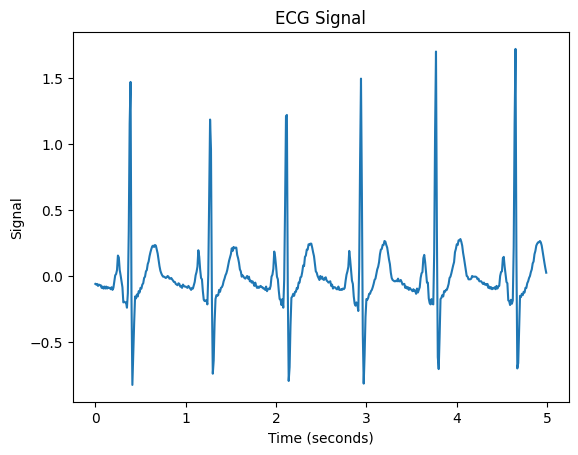

In [ ]:
time_values = np.arange(0, len(p_signal)) / fs

start_time = 0
end_time = 5
start_index = int(start_time * fs)
end_index = int(end_time * fs)

plt.plot(time_values[start_index:end_index], p_signal[start_index:end_index])
plt.xlabel('Time (seconds)')
plt.ylabel('Signal')
plt.title('ECG Signal')
plt.show()

**Filtering the Signal**

In [ ]:
# Filter the ECG signal with a bandpass filter
fs = record.fs  # Sampling frequency of the signal
low_cutoff = 3  # Lower cutoff frequency in Hz
high_cutoff = 45  # Upper cutoff frequency in Hz

In [ ]:
# Design a bandpass filter using a FIR filter
b, a = signal.butter(4, [low_cutoff / (fs / 2), high_cutoff / (fs / 2)], btype='band')

In [ ]:
# Filter the ECG signal
filtered_signal = signal.filtfilt(b, a, p_signal)

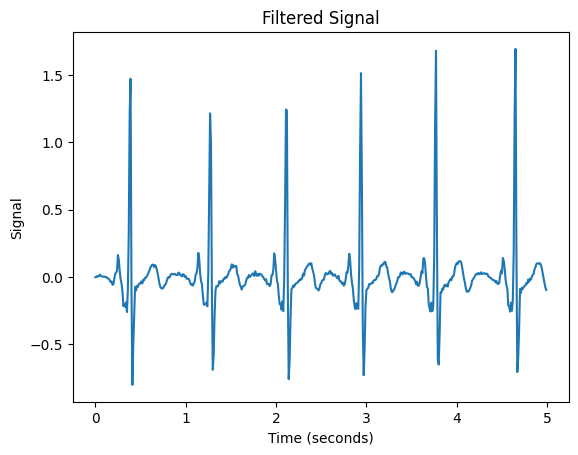

In [ ]:
time_values = np.arange(0, len(filtered_signal)) / fs

start_time = 0
end_time = 5
start_index = int(start_time * fs)
end_index = int(end_time * fs)

plt.plot(time_values[start_index:end_index], filtered_signal[start_index:end_index])
plt.xlabel('Time (seconds)')
plt.ylabel('Signal')
plt.title('Filtered Signal')
plt.show()

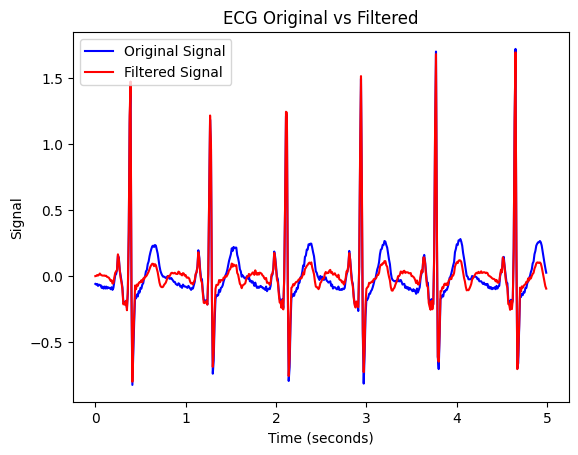

In [ ]:
time_values = np.arange(0, len(p_signal)) / fs

start_time = 0
end_time = 5
start_index = int(start_time * fs)
end_index = int(end_time * fs)

plt.plot(time_values[start_index:end_index], p_signal[start_index:end_index], color='blue', label='Original Signal')
plt.plot(time_values[start_index:end_index], filtered_signal[start_index:end_index], color='red', label='Filtered Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal')
plt.title('ECG Original vs Filtered')
plt.legend()  # Add legend to the plot
plt.show()

**Detecting PQRST**

**R Peaks**

In [ ]:
# Detect R-peaks using biosppy
rpeaks = ecg.ecg(signal=filtered_signal, sampling_rate=fs, show=False)

In [ ]:
# Extract R-peak indices
r_peaks_indices = rpeaks['rpeaks']

# Generate time values
time_values = np.linspace(0, len(filtered_signal) / fs, len(filtered_signal))

In [ ]:
q_points_indices = []
s_points_indices = []
p_wave_indices = []
t_wave_indices = []

**QS**

In [ ]:
# Define the interval duration for Q and S points (in seconds)
interval_duration = 0.08  # 80 ms

# Convert interval duration to number of samples
interval_samples = int(interval_duration * fs)

In [ ]:
for r_peak_index in r_peaks_indices:
    # Calculate the indices for Q and S points
    q_index = max(0, r_peak_index - interval_samples)
    s_index = min(len(filtered_signal) - 1, r_peak_index + interval_samples)

    # Find the index of the lowest signal value in the interval before R-peak for Q point
    q_point_index = np.argmin(filtered_signal[q_index:r_peak_index]) + q_index

    # Find the index of the lowest signal value in the interval after R-peak for S point
    s_point_index = np.argmin(filtered_signal[r_peak_index:s_index]) + r_peak_index

    # Store the indices of Q and S points
    q_points_indices.append(q_point_index)
    s_points_indices.append(s_point_index)

**P**

In [ ]:
# Define the interval duration for the P wave (in seconds)
p_wave_duration = 0.2  # 200 ms

# Convert interval duration to number of samples
p_wave_samples = int(p_wave_duration * fs)

In [ ]:
# Iterate over each Q point index
for q_index in q_points_indices:
    # Calculate the start index of the interval for the P wave
    p_start_index = max(0, q_index - p_wave_samples)

    # Calculate the end index of the interval for the P wave
    p_end_index = min(len(filtered_signal) - 1, q_index)

    # Find the index of the highest signal value in the interval before Q point for the P wave
    p_wave_index = np.argmax(filtered_signal[p_start_index:q_index]) + p_start_index

    # Store the index of the P wave point
    p_wave_indices.append(p_wave_index)

**T**

In [ ]:
# Define the interval duration for the T wave (in seconds)
t_wave_duration = 0.4  # 400 ms

# Convert interval duration to number of samples
t_wave_samples = int(t_wave_duration * fs)

In [ ]:
# Iterate over each S point index
for s_index in s_points_indices:
    # Calculate the start index of the interval for the T wave
    t_start_index = max(0, s_index)

    # Calculate the end index of the interval for the T wave
    t_end_index = min(len(filtered_signal) - 1, s_index + t_wave_samples)

    # Find the index of the highest signal value in the interval after the S point for the T wave
    t_wave_index = np.argmax(filtered_signal[s_index:t_end_index]) + s_index

    # Store the index of the T wave point
    t_wave_indices.append(t_wave_index)

**Plot**

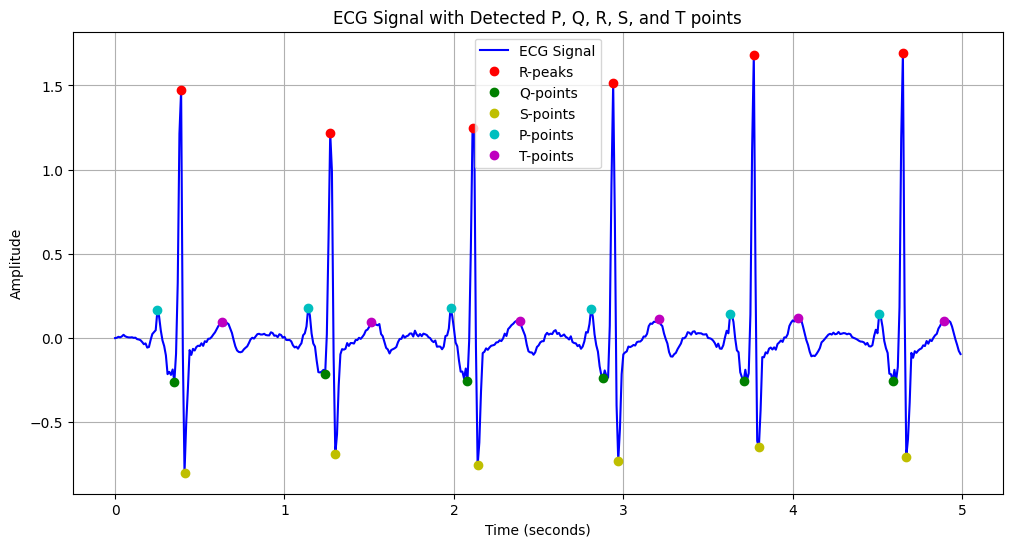

In [ ]:
# Plot the ECG signal with detected P, Q, R, S, and T points
plt.figure(figsize=(12, 6))
plt.plot(time_values[:int(5 * fs)], filtered_signal[:int(5 * fs)], label='ECG Signal', color='blue')
plt.plot(time_values[r_peaks_indices[r_peaks_indices < 5 * fs]], filtered_signal[r_peaks_indices[r_peaks_indices < 5 * fs]], 'ro', label='R-peaks')
plt.plot(time_values[np.array(q_points_indices)[np.array(q_points_indices) < 5 * fs]], filtered_signal[np.array(q_points_indices)[np.array(q_points_indices) < 5 * fs]], 'go', label='Q-points')
plt.plot(time_values[np.array(s_points_indices)[np.array(s_points_indices) < 5 * fs]], filtered_signal[np.array(s_points_indices)[np.array(s_points_indices) < 5 * fs]], 'yo', label='S-points')
plt.plot(time_values[np.array(p_wave_indices)[np.array(p_wave_indices) < 5 * fs]], filtered_signal[np.array(p_wave_indices)[np.array(p_wave_indices) < 5 * fs]], 'co', label='P-points')
plt.plot(time_values[np.array(t_wave_indices)[np.array(t_wave_indices) < 5 * fs]], filtered_signal[np.array(t_wave_indices)[np.array(t_wave_indices) < 5 * fs]], 'mo', label='T-points')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Detected P, Q, R, S, and T points')
plt.legend()
plt.grid(True)
plt.show()

**Collecting Annotations**

In [ ]:
ann = wfdb.rdann('a01', 'apn', pn_dir='apnea-ecg')
apn_sample = ann.sample
apn_symbol = ann.symbol
apn_sample=np.array(apn_sample)
apn_symbol=np.array(apn_symbol)
print(apn_sample)
print(apn_symbol)
print(apn_sample.shape)
print(apn_symbol.shape)

[      0    6000   12000   18000   24000   30000   36000   42000   48000
   54000   60000   66000   72000   78000   84000   90000   96000  102000
  108000  114000  120000  126000  132000  138000  144000  150000  156000
  162000  168000  174000  180000  186000  192000  198000  204000  210000
  216000  222000  228000  234000  240000  246000  252000  258000  264000
  270000  276000  282000  288000  294000  300000  306000  312000  318000
  324000  330000  336000  342000  348000  354000  360000  366000  372000
  378000  384000  390000  396000  402000  408000  414000  420000  426000
  432000  438000  444000  450000  456000  462000  468000  474000  480000
  486000  492000  498000  504000  510000  516000  522000  528000  534000
  540000  546000  552000  558000  564000  570000  576000  582000  588000
  594000  600000  606000  612000  618000  624000  630000  636000  642000
  648000  654000  660000  666000  672000  678000  684000  690000  696000
  702000  708000  714000  720000  726000  732000  7

In [ ]:
# Count occurrences of 'A' and 'N' symbols
count_A = np.count_nonzero(apn_symbol == 'A')
count_N = np.count_nonzero(apn_symbol == 'N')

print("Count of 'A':", count_A)
print("Count of 'N':", count_N)

Count of 'A': 470
Count of 'N': 19


In [ ]:
total_count_A = 0
total_count_N = 0

# Loop through records a01-a20
for i in range(1, 21):
    record_name = 'a{:02d}'.format(i)
    print(record_name)
    ann = wfdb.rdann(record_name, 'apn', pn_dir='apnea-ecg')
    apn_symbol = np.array(ann.symbol)
    count_A = np.count_nonzero(apn_symbol == 'A')
    count_N = np.count_nonzero(apn_symbol == 'N')
    total_count_A += count_A
    total_count_N += count_N

# Loop through records b01-b05
for i in range(1, 6):
    record_name = 'b{:02d}'.format(i)
    print(record_name)
    ann = wfdb.rdann(record_name, 'apn', pn_dir='apnea-ecg')
    apn_symbol = np.array(ann.symbol)
    count_A = np.count_nonzero(apn_symbol == 'A')
    count_N = np.count_nonzero(apn_symbol == 'N')
    total_count_A += count_A
    total_count_N += count_N

# Loop through records c01-c10
for i in range(1, 6):
    record_name = 'c{:02d}'.format(i)
    print(record_name)
    ann = wfdb.rdann(record_name, 'apn', pn_dir='apnea-ecg')
    apn_symbol = np.array(ann.symbol)
    count_A = np.count_nonzero(apn_symbol == 'A')
    count_N = np.count_nonzero(apn_symbol == 'N')
    total_count_A += count_A
    total_count_N += count_N

print("Total Count of 'A':", total_count_A)
print("Total Count of 'N':", total_count_N)

a01
a02
a03
a04
a05
a06
a07
a08
a09
a10
a11
a12
a13
a14
a15
a16
a17
a18
a19
a20
Total Count of 'A': 6250
Total Count of 'N': 3791


**Dividing into windows**

In [ ]:
# Define window size (1 minute)
window_size = fs * 60

# Calculate total number of windows
num_windows = len(filtered_signal) // window_size

if apn_symbol.shape[0] < num_windows:
    num_windows = apn_symbol.shape[0]
elif apn_symbol.shape[0] > num_windows:
    excess_elements = apn_symbol.shape[0] - num_windows
    apn_symbol = apn_symbol[:-excess_elements]

In [ ]:
# Create an empty list to store window arrays
window_arrays = []

# Iterate through each window
for i in range(num_windows):
    start_index = i * window_size
    end_index = (i + 1) * window_size
    window_signal = filtered_signal[start_index:end_index]
    window_arrays.append(window_signal)

# Convert the list of arrays to a numpy array
window_arrays = np.array(window_arrays)

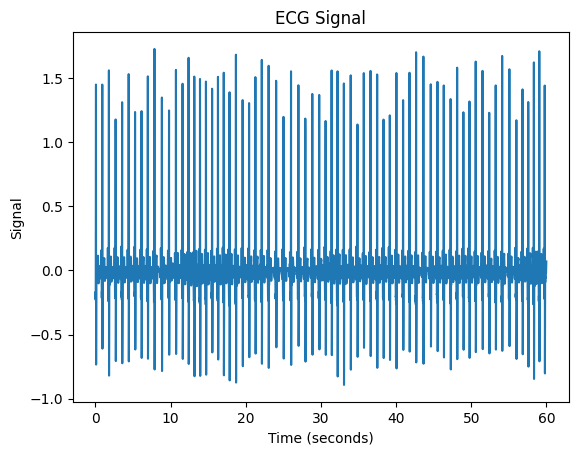

In [ ]:
time_values = np.arange(0, len(window_arrays[10])) / fs

start_time = 0
end_time = 60
start_index = int(start_time * fs)
end_index = int(end_time * fs)

plt.plot(time_values[start_index:end_index], window_arrays[10][start_index:end_index])
plt.xlabel('Time (seconds)')
plt.ylabel('Signal')
plt.title('ECG Signal')
plt.show()

In [ ]:
# Create lists to store indices for each window
window_r_peaks_indices = []
window_q_points_indices = []
window_s_points_indices = []
window_p_wave_indices = []
window_t_wave_indices = []

In [ ]:
for i in range(num_windows):
    start_index = i * window_size
    end_index = (i + 1) * window_size

    # Select the indices within the current window
    window_r_peaks = [peak_idx - start_index for peak_idx in r_peaks_indices if start_index <= peak_idx < end_index]
    window_q_points = [q_idx - start_index for q_idx in q_points_indices if start_index <= q_idx < end_index]
    window_s_points = [s_idx - start_index for s_idx in s_points_indices if start_index <= s_idx < end_index]
    window_p_wave = [p_idx - start_index for p_idx in p_wave_indices if start_index <= p_idx < end_index]
    window_t_wave = [t_idx - start_index for t_idx in t_wave_indices if start_index <= t_idx < end_index]

    # Append the indices for the current window
    window_r_peaks_indices.append(window_r_peaks)
    window_q_points_indices.append(window_q_points)
    window_s_points_indices.append(window_s_points)
    window_p_wave_indices.append(window_p_wave)
    window_t_wave_indices.append(window_t_wave)

In [ ]:
# Verify the lengths of the lists
print("Length of window_r_peaks_indices:", len(window_r_peaks_indices))
print("Length of window_q_points_indices:", len(window_q_points_indices))
print("Length of window_s_points_indices:", len(window_s_points_indices))
print("Length of window_p_wave_indices:", len(window_p_wave_indices))
print("Length of window_t_wave_indices:", len(window_t_wave_indices))

Length of window_r_peaks_indices: 489
Length of window_q_points_indices: 489
Length of window_s_points_indices: 489
Length of window_p_wave_indices: 489
Length of window_t_wave_indices: 489


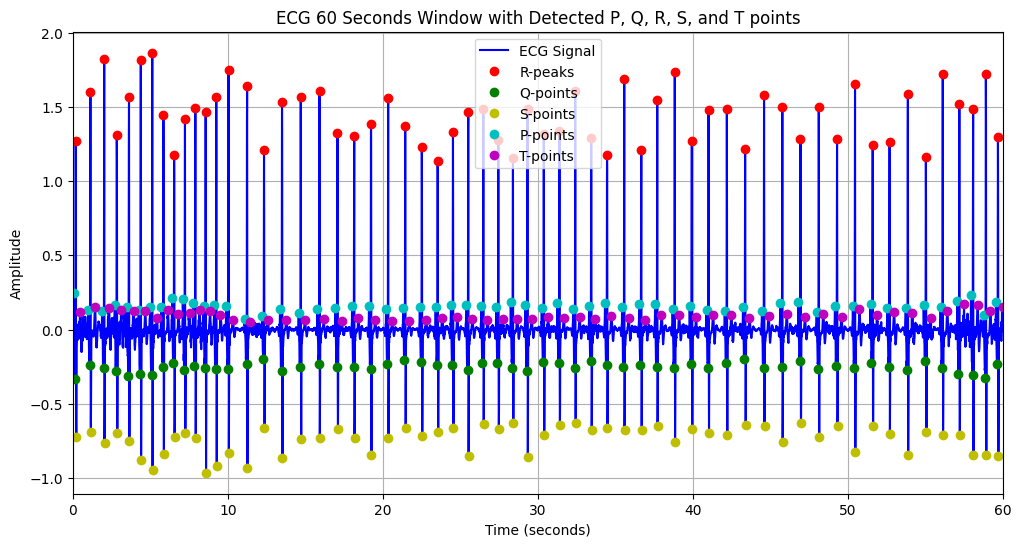

In [ ]:
# Record to be plotted
record=427

# Calculate time values for the first window
time_values = np.arange(0, len(window_arrays[record])) / fs

# Define start and end time for the first 5 seconds
start_time = 0
end_time = 60

# Convert start and end time to corresponding indices
start_index = int(start_time * fs)
end_index = int(end_time * fs)

# Plot the ECG signal with detected P, Q, R, S, and T points for the first 5 seconds of the first window
plt.figure(figsize=(12, 6))
plt.plot(time_values[start_index:end_index], window_arrays[record][start_index:end_index], label='ECG Signal', color='blue')
plt.plot(time_values[np.array(window_r_peaks_indices[record])], window_arrays[record][np.array(window_r_peaks_indices[record])], 'ro', label='R-peaks')
plt.plot(time_values[np.array(window_q_points_indices[record])], window_arrays[record][np.array(window_q_points_indices[record])], 'go', label='Q-points')
plt.plot(time_values[np.array(window_s_points_indices[record])], window_arrays[record][np.array(window_s_points_indices[record])], 'yo', label='S-points')
plt.plot(time_values[np.array(window_p_wave_indices[record])], window_arrays[record][np.array(window_p_wave_indices[record])], 'co', label='P-points')
plt.plot(time_values[np.array(window_t_wave_indices[record])], window_arrays[record][np.array(window_t_wave_indices[record])], 'mo', label='T-points')

# Only show PQRST points that fall within the first 5 seconds
plt.xlim(start_time, end_time)

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG 60 Seconds Window with Detected P, Q, R, S, and T points')
plt.legend()
plt.grid(True)
plt.show()

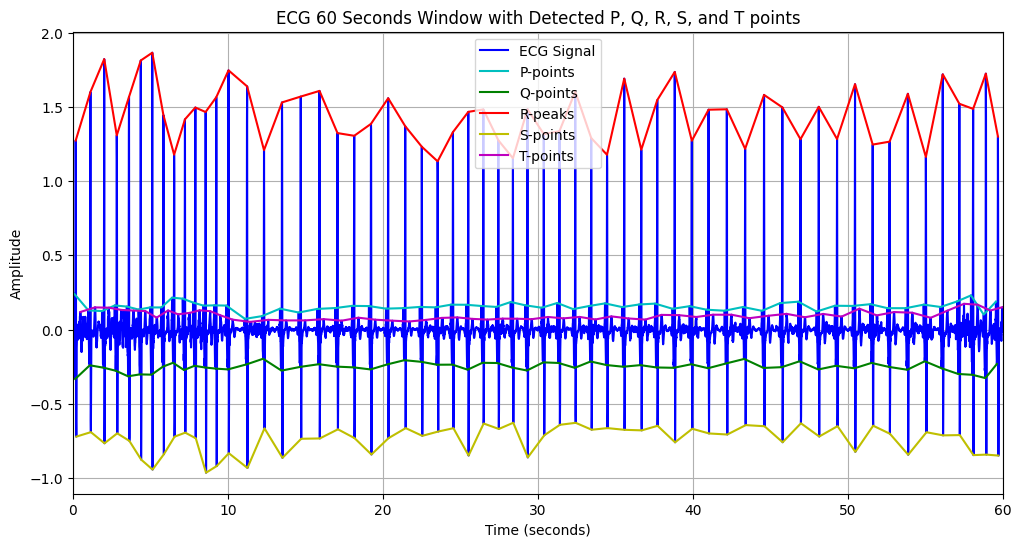

In [ ]:
# Plot the ECG signal with detected P, Q, R, S, and T points for the first 5 seconds of the first window
plt.figure(figsize=(12, 6))
plt.plot(time_values[start_index:end_index], window_arrays[record][start_index:end_index], label='ECG Signal', color='blue')

# Plot lines connecting the detected P, Q, R, S, and T points separately
plt.plot(time_values[np.array(window_p_wave_indices[record])], window_arrays[record][np.array(window_p_wave_indices[record])], 'c-', label='P-points')
plt.plot(time_values[np.array(window_q_points_indices[record])], window_arrays[record][np.array(window_q_points_indices[record])], 'g-', label='Q-points')
plt.plot(time_values[np.array(window_r_peaks_indices[record])], window_arrays[record][np.array(window_r_peaks_indices[record])], 'r-', label='R-peaks')
plt.plot(time_values[np.array(window_s_points_indices[record])], window_arrays[record][np.array(window_s_points_indices[record])], 'y-', label='S-points')
plt.plot(time_values[np.array(window_t_wave_indices[record])], window_arrays[record][np.array(window_t_wave_indices[record])], 'm-', label='T-points')

# Only show PQRST points that fall within the first 5 seconds
plt.xlim(start_time, end_time)

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG 60 Seconds Window with Detected P, Q, R, S, and T points')
plt.legend()
plt.grid(True)
plt.show()

**Binary Representation of PQRST**

In [ ]:
# Create binary representations for each PQRST point
binary_r_peaks = np.zeros_like(window_arrays)
binary_q_points = np.zeros_like(window_arrays)
binary_s_points = np.zeros_like(window_arrays)
binary_p_wave = np.zeros_like(window_arrays)
binary_t_wave = np.zeros_like(window_arrays)

In [ ]:
for i in range(len(window_arrays)):
    binary_r_peaks[i, window_r_peaks_indices[i]] = 1
    binary_q_points[i, window_q_points_indices[i]] = 1
    binary_s_points[i, window_s_points_indices[i]] = 1
    binary_p_wave[i, window_p_wave_indices[i]] = 1
    binary_t_wave[i, window_t_wave_indices[i]] = 1

**Some More Features**

**Avg Heart Rate AvgHR**

In [ ]:
avg_hr_per_window = np.array([len(indices) for indices in window_r_peaks_indices])

In [ ]:
print(avg_hr_per_window)

[67 71 74 80 76 72 73 84 83 73 70 68 66 66 67 65 67 65 68 65 66 65 65 65
 64 64 65 62 65 64 62 63 63 64 64 64 63 64 66 62 61 63 61 61 64 62 63 62
 62 64 61 64 60 61 63 64 61 61 62 61 64 60 59 62 61 58 62 62 57 60 59 60
 60 57 65 58 63 54 78 56 61 61 61 57 62 54 65 63 60 58 67 76 70 63 60 64
 63 64 67 63 66 67 63 67 65 64 67 64 66 67 63 66 64 66 65 67 68 64 65 65
 66 66 65 67 66 66 71 70 69 66 65 67 68 65 66 64 66 65 64 66 70 62 64 70
 62 65 64 67 62 66 64 65 63 66 62 62 61 67 64 73 66 62 63 64 64 62 61 60
 61 62 58 61 62 59 61 61 61 62 61 62 64 58 61 57 58 60 64 61 63 62 69 61
 61 61 59 60 63 58 58 59 63 59 58 54 53 60 54 61 56 55 61 58 62 59 66 63
 55 62 57 55 62 61 59 63 62 56 68 61 73 58 58 58 60 57 59 59 60 60 62 63
 59 60 61 58 60 61 59 61 60 60 60 62 60 61 59 58 66 59 58 60 59 61 60 60
 60 62 58 60 61 56 64 67 61 59 63 59 58 61 58 61 60 60 61 61 60 61 57 57
 61 62 58 61 60 61 59 59 58 58 60 58 56 55 59 60 59 57 60 65 53 62 54 57
 68 64 56 56 57 61 68 58 55 56 54 54 56 59 57 57 62

**Mean R-R Distance meanRR**

In [ ]:
# Calculate the mean R-R interval distance (meanRR) for each window of 60 seconds
mean_rr_per_window = []

for indices in window_r_peaks_indices:
    # Calculate the differences between successive R-R intervals
    rr_intervals = np.diff(indices)

    # Calculate the mean R-R interval distance for the window
    mean_rr = np.mean(rr_intervals)

    # Append the mean R-R interval distance to the list
    mean_rr_per_window.append(mean_rr)

# Convert the list to a NumPy array
mean_rr_per_window = np.array(mean_rr_per_window)

In [ ]:
print(mean_rr_per_window)

[ 90.          83.87142857  81.16438356  74.81012658  79.46666667
  83.          81.625       72.20481928  71.65853659  81.93055556
  86.52173913  88.3880597   90.47692308  91.07692308  89.07575758
  93.15625     89.10606061  92.078125    87.91044776  92.625
  91.83076923  91.375       93.203125    92.28125     92.88888889
  94.9047619   91.734375    95.93442623  92.96875     94.25396825
  95.96721311  95.61290323  94.83870968  93.33333333  93.9047619
  94.3015873   95.11290323  94.11111111  90.81538462  96.19672131
  99.15        95.62903226  97.68333333  98.75        93.85714286
  95.98360656  95.09677419  97.8852459   96.2295082   94.26984127
  98.05        94.66666667  98.57627119  99.16666667  95.24193548
  93.3968254   98.15        97.88333333  97.68852459  98.75
  92.85714286  99.61016949 102.03448276  96.1147541   98.71666667
 104.57894737  96.44262295  95.49180328 106.10714286 101.11864407
 101.13793103  98.33898305 100.44067797 104.875       93.
 103.21052632  95.4516129  111

**Root Mean Square Distance of Successive R-R interval RMSSD**

In [ ]:
# Initialize a list to store the RMS distances for each window
rms_distances_per_window = []

# Iterate through each window
for indices in window_r_peaks_indices:
    # Calculate the differences between successive R-R intervals
    rr_intervals = np.diff(indices)

    # Square each difference
    squared_diffs = rr_intervals ** 2

    # Calculate the mean of the squared differences
    mean_squared_diff = np.mean(squared_diffs)

    # Take the square root of the mean to obtain the RMS distance
    rms_distance = np.sqrt(mean_squared_diff)

    # Append the RMS distance to the list
    rms_distances_per_window.append(rms_distance)

# Convert the list to a NumPy array
rms_distances_per_window = np.array(rms_distances_per_window)

In [ ]:
print(rms_distances_per_window)

[ 90.19457082  83.9973639   81.56206142  75.05592851  79.60234502
  83.19424073  81.76312331  72.33381452  71.96916684  82.17570944
  86.77340139  88.74498094  90.70535562  91.46365398  89.46296
  93.55997408  89.45889525  92.32948811  88.33484463  92.92352366
  92.10002923  91.76089854  93.61632136  92.71191941  93.2503032
  95.30360842  92.08920607  96.32765124  93.52556469  94.54133219
  96.40267325  96.51207513  95.20199239  93.82185077  94.34704595
  94.80163082  95.48391184  94.76746813  92.14228128  96.65334372
  99.62521435  96.27891271  98.36555969  99.39441634  94.63287459
  96.47891131  95.72372881  98.38290868  96.76844087  94.80949989
  98.64338126  95.58740702  98.99614784  99.65390108  95.62687907
  94.36403673  98.81978547  98.44194567  98.17239771  99.38418721
  94.00607883 100.21307807 102.57108553  96.72260488  99.2050906
 105.00718438  97.03920114  96.47976089 107.26003117 103.24300772
 102.7531357  100.67753524 103.63920468 106.64719874  95.33837763
 106.11785901  

**Number of R peaks in ECG that differ more than 50 millisecond NN50**

In [ ]:
# Define the threshold for difference in milliseconds
threshold_ms = 50

# Convert the threshold to samples based on the sampling frequency
threshold_samples = threshold_ms * (fs / 1000)

# Initialize a list to store the count of R peaks exceeding the threshold for each window
NN50_per_window = []

# Iterate through each window
for indices in window_r_peaks_indices:
    # Calculate the differences between successive R-R intervals
    rr_intervals = np.diff(indices)

    # Count the number of differences exceeding the threshold
    diff_exceed_threshold = np.sum(rr_intervals > threshold_samples)

    # Append the count to the list
    NN50_per_window.append(diff_exceed_threshold)

# Convert the list to a NumPy array
NN50_per_window = np.array(NN50_per_window)

In [ ]:
print(NN50_per_window)

[66 70 73 79 75 71 72 83 82 72 69 67 65 65 66 64 66 64 67 64 65 64 64 64
 63 63 64 61 64 63 61 62 62 63 63 63 62 63 65 61 60 62 60 60 63 61 62 61
 61 63 60 63 59 60 62 63 60 60 61 60 63 59 58 61 60 57 61 61 56 59 58 59
 59 56 64 57 62 53 77 55 60 60 60 56 61 53 64 62 59 57 66 75 69 62 59 63
 62 63 66 62 65 66 62 66 64 63 66 63 65 66 62 65 63 65 64 66 67 63 64 64
 65 65 64 66 65 65 70 69 68 65 64 66 67 64 65 63 65 64 63 65 69 61 63 69
 61 64 63 66 61 65 63 64 62 65 61 61 60 66 63 72 65 61 62 63 63 61 60 59
 60 61 57 60 61 58 60 60 60 61 60 61 63 57 60 56 57 59 63 60 62 61 68 60
 60 60 58 59 62 57 57 58 62 58 57 53 52 59 53 60 55 54 60 57 61 58 65 62
 54 61 56 54 61 60 58 62 61 55 67 60 72 57 57 57 59 56 58 58 59 59 61 62
 58 59 60 57 59 60 58 60 59 59 59 61 59 60 58 57 65 58 57 59 58 60 59 59
 59 61 57 59 60 55 63 66 60 58 62 58 57 60 57 60 59 59 60 60 59 60 56 56
 60 61 57 60 59 60 58 58 57 57 59 57 55 54 58 59 58 56 59 64 52 61 53 56
 67 63 55 55 56 60 67 57 54 55 53 53 55 58 56 56 61

**Percentage NN50 pNN50**

In [ ]:
# Initialize a list to store the percentage of NN50 for each window
pNN50_per_window = []

# Iterate through each window
for nn50_count, avg_hr_count in zip(NN50_per_window, avg_hr_per_window):
    # Check if avg_hr_count is non-zero
    if avg_hr_count != 0:
        # Calculate the percentage of NN50 for the window
        pNN50 = (nn50_count / avg_hr_count) * 100
    else:
        # If avg_hr_count is zero, set pNN50 to NaN (or any other desired value)
        pNN50 = np.nan

    # Append the percentage to the list
    pNN50_per_window.append(pNN50)

# Convert the list to a NumPy array
pNN50_per_window = np.array(pNN50_per_window)

In [ ]:
print(pNN50_per_window)

[98.50746269 98.5915493  98.64864865 98.75       98.68421053 98.61111111
 98.63013699 98.80952381 98.79518072 98.63013699 98.57142857 98.52941176
 98.48484848 98.48484848 98.50746269 98.46153846 98.50746269 98.46153846
 98.52941176 98.46153846 98.48484848 98.46153846 98.46153846 98.46153846
 98.4375     98.4375     98.46153846 98.38709677 98.46153846 98.4375
 98.38709677 98.41269841 98.41269841 98.4375     98.4375     98.4375
 98.41269841 98.4375     98.48484848 98.38709677 98.36065574 98.41269841
 98.36065574 98.36065574 98.4375     98.38709677 98.41269841 98.38709677
 98.38709677 98.4375     98.36065574 98.4375     98.33333333 98.36065574
 98.41269841 98.4375     98.36065574 98.36065574 98.38709677 98.36065574
 98.4375     98.33333333 98.30508475 98.38709677 98.36065574 98.27586207
 98.38709677 98.38709677 98.24561404 98.33333333 98.30508475 98.33333333
 98.33333333 98.24561404 98.46153846 98.27586207 98.41269841 98.14814815
 98.71794872 98.21428571 98.36065574 98.36065574 98.3606557

**Standard Deviation of R-R series SD_RR**

In [ ]:
# Initialize a list to store the SD_RR for each window
sd_rr_per_window = []

# Iterate through each window
for indices in window_r_peaks_indices:
    # Calculate the differences between successive R-R intervals
    rr_intervals = np.diff(indices)

    # Calculate the standard deviation of the R-R intervals for the window
    sd_rr = np.std(rr_intervals)

    # Append the SD_RR to the list
    sd_rr_per_window.append(sd_rr)

# Convert the list to a NumPy array
sd_rr_per_window = np.array(sd_rr_per_window)

In [ ]:
print(sd_rr_per_window)

[ 5.92119971  4.59789215  8.04442068  6.06937936  4.64566704  5.68169782
  4.75054821  4.31796203  6.67945432  6.34281393  6.60392658  7.95126053
  6.43334509  8.4020285   8.31448281  8.68227136  7.93749977  6.80832369
  8.64858084  7.44248782  7.0374148   8.40665659  8.78596126  8.92585561
  8.20203442  8.70999114  8.07628122  8.69495586 10.19032745  7.3656609
  9.1525634  13.14356808  8.30894106  9.56182887  9.12473402  9.72418833
  8.40910574 11.1342616  15.58094725  9.38401094  9.71909632 11.16768649
 11.5650215  11.29988938 12.09205057  9.76358541 10.93781496  9.88308434
 10.19867147 10.10140073 10.8034331  13.23535429  9.10802103  9.84236873
  8.57168159 13.47606895 11.4859697  10.47233127  9.73508272 11.20955693
 14.65243589 10.97611729 10.47816369 10.82664951  9.83207619  9.47378168
 10.74369749 13.77170174 15.68402118 20.83598968 18.14733596 21.57337512
 25.54906956 19.36128547 20.98585833 24.66956136 15.96738351 17.22727271
 10.0507231  14.50544497 21.22828302 18.31972222 11.

**Standard Deviation of Heart Rate SD_HR**

In [ ]:
# Initialize a list to store the SD_HR for each window
sd_hr_per_window = []

# Iterate through each window
for indices in window_r_peaks_indices:
    # Calculate the differences between successive R-R intervals
    rr_intervals = np.diff(indices)

    # Convert R-R intervals to heart rates (beats per minute)
    heart_rates = 60 / rr_intervals

    # Calculate the standard deviation of heart rate for the window
    sd_hr = np.std(heart_rates)

    # Append the SD_HR to the list
    sd_hr_per_window.append(sd_hr)

# Convert the list to a NumPy array
sd_hr_per_window = np.array(sd_hr_per_window)

In [ ]:
print(sd_hr_per_window)

[0.04430245 0.04077944 0.07417338 0.07019723 0.04410798 0.05242772
 0.04201527 0.04929055 0.07478689 0.05543665 0.0540407  0.0655024
 0.04699295 0.06423235 0.06505619 0.05974845 0.06293873 0.05009598
 0.06890604 0.05301486 0.0510926  0.06349636 0.06089526 0.0649004
 0.05783074 0.05912763 0.05780681 0.05931928 0.07093105 0.05289931
 0.05970822 0.10289369 0.05696912 0.06559168 0.07080529 0.06762893
 0.05367125 0.08105728 0.12252666 0.06373001 0.06066088 0.07565973
 0.07147296 0.07001609 0.08593703 0.06629126 0.07500615 0.06322876
 0.06883278 0.07005506 0.07135712 0.08960432 0.06051343 0.0634296
 0.06313723 0.10076521 0.07718329 0.0698387  0.06129138 0.07396803
 0.11310715 0.07249421 0.06520864 0.07384682 0.06386782 0.05659206
 0.06846471 0.09352588 0.09278221 0.1450053  0.11371553 0.15362973
 0.17579465 0.13021033 0.13316088 0.17634825 0.10743447 0.11884027
 0.10655284 0.07697604 0.14157311 0.1321775  0.08394177 0.09451595
 0.11778031 0.11540158 0.15346828 0.09027539 0.10878442 0.0921210

**Power Spectral Entropy PSE**

In [ ]:
# Initialize a list to store the PSE for each window
pse_per_window = []

# Iterate through each window
for window_signal in window_arrays:
    # Compute the power spectral density (PSD) using Welch's method
    f, psd = welch(window_signal, fs=fs)

    # Check if the PSD contains zero or very small values
    if np.sum(psd) == 0 or np.any(psd < 1e-10):
        # If so, set the PSD to a small positive value to avoid division by zero
        psd = np.ones_like(psd) * 1e-10

    # Normalize the PSD
    normalized_psd = psd / np.sum(psd)

    # Compute the entropy of the normalized PSD
    pse = entropy(normalized_psd)

    # Append the PSE to the list
    pse_per_window.append(pse)

# Convert the list to a NumPy array
pse_per_window = np.array(pse_per_window)

In [ ]:
print(pse_per_window)

[4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124 4.8598124
 4.859

**Average Heart Rate Variability average_hrv**

In [ ]:
# Initialize a list to store the average HRV for each window
average_hrv_per_window = []

# Iterate through each window
for window_indices in window_r_peaks_indices:
    # Calculate the differences between successive R-R intervals
    rr_intervals = np.diff(window_indices)

    # Compute the standard deviation of RR intervals (SDRR)
    sd_rr = np.std(rr_intervals)

    # Append the SDRR to the list
    average_hrv_per_window.append(sd_rr)

# Convert the list to a NumPy array
average_hrv_per_window = np.array(average_hrv_per_window)

In [ ]:
print(average_hrv_per_window)

[ 5.92119971  4.59789215  8.04442068  6.06937936  4.64566704  5.68169782
  4.75054821  4.31796203  6.67945432  6.34281393  6.60392658  7.95126053
  6.43334509  8.4020285   8.31448281  8.68227136  7.93749977  6.80832369
  8.64858084  7.44248782  7.0374148   8.40665659  8.78596126  8.92585561
  8.20203442  8.70999114  8.07628122  8.69495586 10.19032745  7.3656609
  9.1525634  13.14356808  8.30894106  9.56182887  9.12473402  9.72418833
  8.40910574 11.1342616  15.58094725  9.38401094  9.71909632 11.16768649
 11.5650215  11.29988938 12.09205057  9.76358541 10.93781496  9.88308434
 10.19867147 10.10140073 10.8034331  13.23535429  9.10802103  9.84236873
  8.57168159 13.47606895 11.4859697  10.47233127  9.73508272 11.20955693
 14.65243589 10.97611729 10.47816369 10.82664951  9.83207619  9.47378168
 10.74369749 13.77170174 15.68402118 20.83598968 18.14733596 21.57337512
 25.54906956 19.36128547 20.98585833 24.66956136 15.96738351 17.22727271
 10.0507231  14.50544497 21.22828302 18.31972222 11.

**Features and Labels**

In [ ]:
expanded_features = []
expanded_features = np.repeat(np.expand_dims(np.stack([avg_hr_per_window, mean_rr_per_window, rms_distances_per_window, NN50_per_window, pNN50_per_window, sd_rr_per_window, sd_hr_per_window, pse_per_window, average_hrv_per_window], axis=1), axis=1), 6000, axis=1)

In [ ]:
features = np.concatenate((window_arrays[:, :, np.newaxis],
                                    binary_r_peaks[:, :, np.newaxis],
                                    binary_q_points[:, :, np.newaxis],
                                    binary_s_points[:, :, np.newaxis],
                                    binary_p_wave[:, :, np.newaxis],
                                    binary_t_wave[:, :, np.newaxis],
                                    ), axis=2)

In [ ]:
print(features.shape)

In [ ]:
labels = apn_symbol

# Convert labels to binary values (0 or 1)
labels = np.array([1 if label == 'A' else 0 for label in labels])

In [ ]:
# Assuming features and labels are numpy arrays
features, labels = shuffle(features, labels, random_state=42)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

**CNN Conv1D**

In [ ]:
# Define the CNN model
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [ ]:
# Define the model
model = Sequential([
    Conv1D(64, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 5996, 64)          1984      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 2998, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 2996, 128)         24704     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 1498, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 1496, 256)         98560     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 748, 256)         

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10
13/13 - 47s - loss: 0.3981 - accuracy: 0.9463 - val_loss: 0.1628 - val_accuracy: 0.9694 - 47s/epoch - 4s/step
Epoch 2/10
13/13 - 43s - loss: 0.2288 - accuracy: 0.9591 - val_loss: 0.2417 - val_accuracy: 0.9694 - 43s/epoch - 3s/step
Epoch 3/10
13/13 - 44s - loss: 0.1988 - accuracy: 0.9591 - val_loss: 0.1644 - val_accuracy: 0.9694 - 44s/epoch - 3s/step
Epoch 4/10
13/13 - 43s - loss: 0.1731 - accuracy: 0.9591 - val_loss: 0.1625 - val_accuracy: 0.9694 - 43s/epoch - 3s/step
Epoch 5/10
13/13 - 43s - loss: 0.1459 - accuracy: 0.9591 - val_loss: 0.1639 - val_accuracy: 0.9694 - 43s/epoch - 3s/step
Epoch 6/10
13/13 - 43s - loss: 0.1416 - accuracy: 0.9591 - val_loss: 0.1519 - val_accuracy: 0.9694 - 43s/epoch - 3s/step
Epoch 7/10
13/13 - 43s - loss: 0.0932 - accuracy: 0.9591 - val_loss: 0.1598 - val_accuracy: 0.9694 - 43s/epoch - 3s/step
Epoch 8/10
13/13 - 46s - loss: 0.0625 - accuracy: 0.9591 - val_loss: 0.2734 - val_accuracy: 0.9694 - 46s/epoch - 4s/step
Epoch 9/10
13/13 - 44s - loss: 0

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

3/3 [==============================] - 3s 863ms/step - loss: 6.6615e-19 - accuracy: 1.0000
Test Loss: 6.661535178036946e-19
Test Accuracy: 1.0


In [ ]:
# Save the model
model.save("sleep_apnea_detection_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
for i in range(489):
  # Take the first window from window_arrays
  window_data = window_arrays[i]

  # Reshape the window data to fit the input shape of the CNN model
  window_data = window_data.reshape(1, len(window_data), 1)

  # Make predictions using the model
  prediction = model.predict(window_data)

  # Print the predicted probability of sleep apnea (class A)
  print("Predicted Probability of Sleep Apnea (A):", prediction[0][0])